In [1]:
# import packages 
import numpy as np 
import torch
import os 
import json
import matplotlib.pyplot as plt 
from string import ascii_lowercase as alc
from torch.utils.data import Dataset, DataLoader 
import torch.nn.functional as F 
import torch.optim as optim 
import torch.nn as nn 
from tensorflow import keras

2023-02-27 16:37:34.326954: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# Check if we have GPU access, and display which GPU we can access 
print(torch.cuda.is_available())
device_index = torch.cuda.current_device()
device_name = torch.cuda.get_device_name(device_index)
print(device_index)
print(device_name)

True
0
Tesla T4


In [3]:
#from utils import read_data,label_mapping_FEMNIST
from utils import *
from models import Net, Federated_Averaging, Global_Model,Local_Model,AFPL,training_loop
from data import FEMNIST_dataset, Partition_MNIST_NIID,MNIST_NIID_dataset

import yaml 
stream = 'settings\train_settings.yaml'
with open('settings/train_settings.yaml','r') as file:
    settings = yaml.safe_load(file)
    
print(settings)

{'experiment_name': 'test_adaptive_a4', 'Date': '22_11_2022', 'Dataset': 'MNIST_niid', 'n_clients': 10, 'total_clients': 10, 'classes_per_user': 10, 'network': 'Net', 'n_epochs': 100, 'local_iterations': 1, 'type': 'afpl', 'log_interval': 25}


### Personalized Peer-to-Peer Federated Averaging 

Divide the dataset over 10 clients, in such a way that each client gets 2 classes. 

In [4]:
### Divide MNIST dataset over a total of 10 clients. Each client gets 2 classes.
train_data, test_data = keras.datasets.mnist.load_data()
instance = Partition_MNIST_NIID(train_data[0],train_data[1])
classes_per_user = 2
total_clients = 10
train_partition = instance.create_partition(4,classes_per_user,total_clients)
test_instance = Partition_MNIST_NIID(test_data[0], test_data[1])
test_partition = test_instance.create_partition_test(instance.sample_array)

[[1 2]
 [0 1]
 [0 1]
 [3 1]
 [3 0]
 [0 1]
 [0 1]
 [3 2]
 [0 2]
 [3 1]]


Because client 4 and client 9 have exactly the same samples, we expect those alphas to be similar. Now, distribute the same initial model to all clients. 
5 6 7 

In [5]:
from torch.utils.data import DataLoader
import copy
network = Net('MNIST_niid')
client_models = {}
optimizers = {}
dataloaders = {}
dataloaders_test = {}
for i in range(total_clients):
    client_models[str(i)] = copy.deepcopy(network).double().cuda()
    optimizers[str(i)] = torch.optim.SGD(client_models[str(i)].parameters(),lr=0.01,momentum=0.5)
    dataset_train= MNIST_NIID_dataset(train_data[0],train_data[1],train_partition,i)
    dataloaders[str(i)] = DataLoader(dataset_train,batch_size=16,shuffle=True)
    dataset_test= MNIST_NIID_dataset(test_data[0],test_data[1],test_partition,i)
    dataloaders_test[str(i)] = DataLoader(dataset_test,batch_size=16,shuffle=True)


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
import random
# Select 5 clients 
selected_clients = [1,2,5,6] #[4,8,9]
# create a (random) graph between them
graph = []
for index,sample in enumerate(selected_clients):
    other_clients = copy.deepcopy(selected_clients)
    other_clients.remove(sample)
    l = [i for i in other_clients]
    graph.append(random.sample(l,k=2))
    
print(graph)

Let each of the $m$ selected clients train locally to find their own $\Delta w_i$

Exchange models, compute alpha and update 

In [243]:

def flatten(source):
    list1 = []
    for value in source: 
     #  print(value.flatten().shape)
       list1.append(value.flatten())
    #print(len(list1))
    return torch.cat(list1) #deepcopy(value).flatten() for value in source])


class P2P_AFPL():
    def __init__(self,total_clients,train_data,train_partition,test_data,test_partition): 
        network = Net('MNIST_niid')
        self.total_clients = total_clients 
        self.client_models = {}
        self.optimizers = {}
        self.dataloaders = {}
        self.dataloaders_test = {}
        for i in range(total_clients):
            self.client_models[str(i)] = copy.deepcopy(network).double().cuda()
            self.optimizers[str(i)] = torch.optim.SGD(self.client_models[str(i)].parameters(),lr=0.01,momentum=0.5)
            dataset_train= MNIST_NIID_dataset(train_data[0],train_data[1],train_partition,i)
            self.dataloaders[str(i)] = DataLoader(dataset_train,batch_size=16,shuffle=True)
            dataset_test= MNIST_NIID_dataset(test_data[0],test_data[1],test_partition,i)
            self.dataloaders_test[str(i)] = DataLoader(dataset_test,batch_size=16,shuffle=True)
            
    def pairwise_angles(self,selected_clients): 
        angles = torch.zeros([self.total_clients,self.total_clients])
        print(angles.shape)
        for i in selected_clients:
            for j in selected_clients:
                list1 = [] #[copy.deepcopy(self.client_models[str(client)]).parameters() for client in selected_clients]
                list2 = []
                for value1,value2 in zip(self.client_models[str(i)].parameters(),self.client_models[str(j)].parameters()): 
                    list1.append(value1.flatten())
                    list2.append(value2.flatten())
                s1 = torch.cat(list1)

                s2 = torch.cat(list2)
                angles[i,j] = torch.sum(s1*s2)/(torch.norm(s1)*torch.norm(s2)+1e-8)
        return angles.detach().numpy()

    def create_graph(self,selected_clients):
        graph = []
        for index,sample in enumerate(selected_clients):
            other_clients = copy.deepcopy(selected_clients)
            other_clients.remove(sample)
            l = [i for i in other_clients]
            graph.append(random.sample(l,k=2))

        return graph 
    
    def select_clients(self, n_clients=1,total_clients=1, seed=1):
        random.seed(seed)
        l = [i for i in range(total_clients)]
        self.selected_clients = random.sample(l,k=n_clients)
        return self.selected_clients 

    def update_local_models(self,selected_clients):
        self.dw = {}
        for idx,i in enumerate(selected_clients):
            #local_model = self.client_models[str(i)]
            #local_optimizer = 
            #self.client_models[str(i)].train()
            
            dataloader = self.dataloaders[str(i)]
            
            for batch_idx, (data, target) in enumerate(dataloader):
                data = data.double().cuda()
                target=target.long().cuda()

                self.optimizers[str(i)].zero_grad()
                output = self.client_models[str(i)](data)
                loss = F.nll_loss(output,target)
                loss.backward()
                self.optimizers[str(i)].step()
                
            dataloader_test = self.dataloaders_test[str(i)]
            loss_test = 0 
            with torch.no_grad():
                for batch_idx, (data, target) in enumerate(dataloader_test):
                    data = data.double().cuda()
                    target=target.long().cuda()

                    output = self.client_models[str(i)](data)
                    loss_test += F.nll_loss(output,target)
            #print("test loss before tuning alpha")
            #print(loss_test)   
    
    def update_alpha_gd(self,ii,selected_clients,graph,alpha_init = torch.tensor([0.33, 0.33]).cuda()):
        alphas = torch.nn.Parameter(alpha_init, requires_grad=True)
        optimizer_alpha = torch.optim.Adam([alphas])
        local_graph = graph[ii]
        #print(local_graph)
        i = selected_clients[ii]
        dataloader = self.dataloaders_test[str(i)]
        local_model = self.client_models[str(i)]
        neigh1 = self.client_models[str(local_graph[0])]
        neigh2 = copy.deepcopy(self.client_models[str(local_graph[1])])
        loss_test = 0 
        local_model.eval()
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(dataloader):
                data = data.double().cuda()
                target=target.long().cuda()

                output = local_model(data)
                loss_test += F.nll_loss(output,target)
        #print("sanity check 1")
        #print(loss_test) 
        #for local_param,local_param2,local_param3 in zip(local_model.parameters(),neigh1.parameters(),neigh2.parameters()):
          #  local_param.data = local_param.data*(1-alphas[0]-alphas[1]) + local_param2.data*alphas[0] + local_param3.data*alphas[1]
        
        grad_alpha = 0
        alpha = alphas[0]
        for l_params, p_params in zip(local_model.parameters(), neigh1.parameters()): ### Adjust this back to global_model to follow the official implementation
            dif = p_params.data - l_params.data
            #print(dif)
            grad = alpha * p_params.grad.data + (1 - alpha) * l_params.grad.data
            grad_alpha += dif.view(-1).T.dot(grad.view(-1))
            

        #grad_alpha += 0.02 * alpha
        learning_rate = 0.1
        alpha = alpha - learning_rate * grad_alpha
        alphas = np.clip(alpha.item(), 0.0, 1.0)
        
        #for batch_idx, (data, target) in enumerate(dataloader):
         #   data = data.double().cuda()
         #   target=target.long().cuda()

         #   optimizer_alpha.zero_grad()

         #   output = local_model(data) #alphas[0]*neigh1(data) + alphas[1]*neigh2(data) + (1-alphas[0]-alphas[1])*local_model(data)
          #  loss = F.nll_loss(output,target)
          #  loss.backward()
          #  optimizer_alpha.step()
          #  alphas_new = torch.clip(alphas,min=0,max=1).detach()
            
         #   alphas = torch.nn.Parameter(alphas_new, requires_grad=True)
         #   optimizer_alpha = torch.optim.Adam([alphas])
            
        loss_test = 0 
        self.client_models[str(i)].eval()
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(dataloader):
                data = data.double().cuda()
                target=target.long().cuda()

                output = local_model(data)
                loss_test += F.nll_loss(output,target)
        
        loss_test = 0 
        loss_test2 = 0 
        losses1 = 0 
        losses2 = 0 
        losses3 = 0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(dataloader):
                data = data.double().cuda()
                target=target.long().cuda()

                #output = local_model(data)
                output = local_model(data)
                loss_test2 += F.nll_loss(output,target)
                #output = alphas[0]*neigh1(data) + alphas[1]*neigh2(data) + (1-alphas[0]-alphas[1])*local_model(data)
                loss1 = F.nll_loss(neigh1(data),target)
                #loss2 = F.nll_loss(neigh2(data),target)
                loss3 = F.nll_loss(local_model(data),target)
                losses1 += loss1 
                #losses2 += loss2 
                losses3 += loss3
                #loss_test += alphas[0]*loss1 + alphas[1]*loss2 + (1-alphas[0]-alphas[1])*loss3
                #loss_test += F.nll_loss(output,target)
        #print("before combining alphas")
        #print(loss_test2)  
        #print("after combining alphas")
        #print(loss_test)  
        #print("loss1")
        #print(losses1)
        #print("loss2")
        #print(losses2)
        #print("loss3")
        #print(losses3)
        #print(alphas[0]*neigh1(data))
        #print(alphas[1]*neigh2(data))
        #print((1-alphas[0]-alphas[1])*local_model(data))
        #print(alphas[0])
        #print(alphas[1])
        
        # update the local model with this new optimal alpha
        #for ii,neighbour in enumerate(local_graph): 
        #    for param_own,param_neighbour in zip(self.client_models[str(i)].parameters(),self.client_models[str(neighbour)].parameters()):
        #        param_own = param_own + alphas[ii]*param_neighbour 
         
        #loss_test = 0 
        #with torch.no_grad():
        #    for batch_idx, (data, target) in enumerate(dataloader):
        #        data = data.double().cuda()
        #        target=target.long().cuda()

        #        output = self.client_models[str(i)](data)
        #        loss_test += F.nll_loss(output,target)
        #print("test loss after tuning alpha")
        #print(loss_test)  
        
        return np.array([ alphas, alphas])
    
    def update_alpha_cos(self,selected_clients,graph):
        #lphas = torch.nn.Parameter(alpha_init, requires_grad=True)
        #optimizer_alpha = torch.optim.Adam([alphas])
        #local_graph = graph[ii]
        #i = selected_clients[ii]
        #dataloader = self.dataloaders[str(i)]
        print(selected_clients)
        alphas = self.pairwise_angles(selected_clients) #[copy.deepcopy(self.client_models[str(client)]).parameters() for client in selected_clients])
        print(alphas)
        return alphas 
        #os = nn.CosineSimilarity(dim=1,eps=1e-6)
        
        #or iii in range(len(local_graph)):
        #   neighbour = local_graph[iii]
         #  for param_own,param_neighbour in zip(self.client_models[str(i)].parameters(),self.client_models[str(neighbour)].parameters()): 
         #      
          #     print(param_own.shape)
          #     similarity_param = cos(param_own,param_neighbour)
           #    print(similarity_param.shape)
                
    
    def loop(self,epochs,graph,mode='disjoint'):
        selected_clients = [1,2,5,6]
        list1 = []
        self.alphas = torch.ones(self.total_clients,self.total_clients)*(1/3)
        self.update_local_models(selected_clients)
        for i in range(epochs):
            print(i)
            #selected_clients = self.select_clients(n_clients=10,total_clients=self.total_clients,seed=i)
            #print(selected_clients)
            #graph = self.create_graph(selected_clients)
            #print(graph)
            # normally: select clients and create graph now 
            
            
            #self.update_local_models(selected_clients)
            
            
            # normally: exchange models between the clients 
            if mode == 'disjoint': 
                #alphas = self.update_alpha_cos(selected_clients,graph)
                for ii in range(len(selected_clients)):
                    temp_alpha = torch.tensor([self.alphas[selected_clients[ii],graph[ii][0]],self.alphas[selected_clients[ii],graph[ii][1]]]).cuda()
                    alphas_new = self.update_alpha_gd(ii,selected_clients,graph,temp_alpha)
                    for j in range(len(alphas_new)):
                        self.alphas[selected_clients[ii],graph[ii][j]] = alphas_new[j] #.detach()
            #print(self.alphas[4,:])
            #print(alphas)
            a = self.alphas #.numpy()
            ##blub = np.array([[a[4,4],a[4,8],a[4,9]],[a[8,4],a[8,8],a[8,9]],[a[9,4],a[9,8],a[9,9]]])
            #print(blub)
            blub = np.array([[a[1,1],a[1,2],a[1,5],a[1,6]],[a[2,1],a[2,2],a[2,5],a[2,6]],[a[5,1],a[5,2],a[5,5],a[5,6]],[a[6,1],a[6,2],a[6,5],a[6,6]]])
            print(blub[0,1])
            list1.append(blub[0,1])
        return list1
            
            
        

In [244]:
p2p = P2P_AFPL(total_clients,train_data,train_partition,test_data,test_partition)
alphas = p2p.loop(5,graph)

0
0.33331943
1
0.33330554
2
0.33329165
3
0.33327776
4
0.3332639


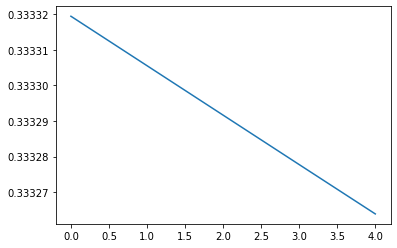

In [245]:
plt.plot(alphas)

In [104]:
print(graph)

[[8, 9], [9, 4], [8, 4]]


In [126]:
a = alphas.numpy()
blub = np.array([[a[4,4],a[4,8],a[4,9]],[a[8,4],a[8,8],a[8,9]],[a[9,4],a[9,8],a[9,9]]])
print(blub)

[[0.33333334 0.         0.37547827]
 [0.33333334 0.33333334 0.33333334]
 [0.33333334 0.33333334 0.33333334]]


In [122]:
a = alphas.numpy()
blub = np.array([[a[4,4],a[4,8],a[4,9]],[a[8,4],a[8,8],a[8,9]],[a[9,4],a[9,8],a[9,9]]])
print(blub)

[[0.         0.         0.15288837]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]


In [99]:
a = alphas.numpy()
blub = np.array([[a[4,4],a[4,8],a[4,9]],[a[8,4],a[8,8],a[8,9]],[a[9,4],a[9,8],a[9,9]]])
print(blub)

[[0.0000000e+00 7.9999575e-03 6.9999979e-03]
 [9.9999877e-04 0.0000000e+00 1.2599930e-01]
 [4.9266963e-10 1.2999872e-02 0.0000000e+00]]


In [64]:
from sklearn.cluster import AgglomerativeClustering 
distances = 1-alphas 
distances_fit = np.array([[distances[4,4],distances[4,8],distances[4,9]],
                          [distances[4,8],distances[8,8],distances[4,9]],
                          [distances[4,9],distances[8,9],distances[9,9]]])
model = AgglomerativeClustering(affinity='precomputed',n_clusters=2,linkage='complete').fit(distances_fit)
print(model.labels_)

[0 0 1]


In [219]:
p2p = P2P_AFPL(total_clients,train_data,train_partition)
p2p.update_local_models(selected_clients)
alphas = p2p.update_alpha(ii,selected_clients,graph)
alphas2 = update_alpha(ii,selected_clients,p2p.dataloaders,p2p.client_models,graph)
print(alphas)

Parameter containing:
tensor([0.1990, 0.3300], device='cuda:0', requires_grad=True)


In [220]:
#alphas2 = update_alpha(ii,selected_clients,p2p.dataloaders,p2p.client_models,graph)
print(alphas2)

Parameter containing:
tensor([0.1980, 0.3320], device='cuda:0', requires_grad=True)


In [202]:
ii = 3
alphas = update_alpha(ii,selected_clients,dataloaders,client_models,graph)
print(alphas)

Parameter containing:
tensor([0.1980, 0.3360], device='cuda:0', requires_grad=True)


In [ ]:
# Update alphas and models simultaneously 




In [189]:
i = str(6)
epochs = 10
learning_rate = 0.001
alpha = [0.33, 0.33, 0.33]
alphas_0 = []
alphas_1 = []
alphas_2 = []
alphas_01 = []
alphas_11 = []
alphas_21 = []
alphas = torch.nn.Parameter(torch.tensor([0.33,0.33]).cuda(), requires_grad=True)
optimizer_alpha = torch.optim.Adam([alphas])
for iteration in range(epochs):#enumerate(selected_clients):
    grad_alpha = 0 
    
    local_graph = graph[3]
    #print(local_graph[0])
    #for idx2,q in enumerate(graph[idx]):
        # We receive client model q from client q and compute the difference with our own model
    #difference2 = client_models[str(local_graph[0])]-client_models[i]
    #difference3 = client_models[str(local_graph[1])]-client_models[i]
    df_da2 = 0 
    df_da3 = 0
    #optimizer_alpha.grad_zero()
    for two_params,three_params,l_params in zip(client_models[str(local_graph[0])].parameters(), client_models[str(local_graph[1])].parameters(),client_models[str(i)].parameters()):
        grad = alpha[0] * l_params.grad.data + alpha[1]*two_params.grad.data + alpha[2]*three_params.grad.data 
        difference2 = two_params.grad - l_params.grad 
        difference3 = three_params.grad - l_params.grad
        df_da2 += difference2.view(-1).T.dot(grad.view(-1))
        df_da3 += difference3.view(-1).T.dot(grad.view(-1))
    alpha[1] = torch.clip(alpha[1] - learning_rate*df_da2,0,1)
    alpha[2] = torch.clip(alpha[2]- learning_rate*df_da3,0,1)
    alpha[0] = 1 - alpha[1]-alpha[2]
    
    alphas_0.append(alpha[0].detach().cpu().numpy())
    alphas_1.append(alpha[1].detach().cpu().numpy())
    alphas_2.append(alpha[2].detach().cpu().numpy())
    
    
    dataloader = dataloaders[str(i)]
    
    for batch_idx, (data, target) in enumerate(dataloader):
        data = data.double().cuda()
        target=target.long().cuda()
        
        optimizer_alpha.zero_grad()
        
        output = alphas[0]*client_models[str(local_graph[0])](data) + alphas[1]*client_models[str(local_graph[1])](data) + (1-alphas[0]-alphas[1])*client_models[str(i)](data)
        loss = F.nll_loss(output,target)
        loss.backward()
        optimizer_alpha.step()
    alphas_new = torch.clip(alphas,min=0,max=1).detach()
    alphas = torch.nn.Parameter(alphas_new, requires_grad=True)
    optimizer_alpha = torch.optim.Adam([alphas])
        
        
    alphas_01.append(1-alphas[0].detach().cpu().numpy()-alphas[1].detach().cpu().numpy())
    alphas_11.append(alphas[0].detach().cpu().numpy())
    alphas_21.append(alphas[1].detach().cpu().numpy())
    

[array(0.1990253, dtype=float32), array(0.06826229, dtype=float32), array(0., dtype=float32), array(0., dtype=float32), array(0., dtype=float32), array(0., dtype=float32), array(0., dtype=float32), array(0., dtype=float32), array(0., dtype=float32), array(0., dtype=float32)]
[array(0.35240844, dtype=float32), array(0.37458596, dtype=float32), array(0.38733503, dtype=float32), array(0.39806187, dtype=float32), array(0.4027286, dtype=float32), array(0.41847777, dtype=float32), array(0.41902542, dtype=float32), array(0.41439006, dtype=float32), array(0.43056893, dtype=float32), array(0.43127424, dtype=float32)]


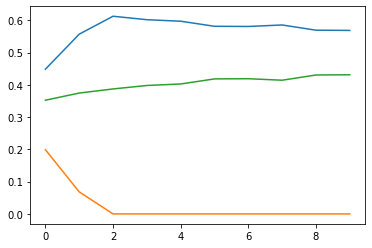

In [194]:
import matplotlib.pyplot as plt 
plt.figure()
plt.plot(alphas_01)
plt.plot(alphas_11)
plt.plot(alphas_21)
print(alphas_11)
print(alphas_21)

In [174]:
alphas_0 = []
alphas_1 = []
alphas_2 = []
epochs = 10

for iteration in range(epochs):#enumerate(selected_clients):
    grad_alpha = 0 
    
    local_graph = graph[3]
    #print(local_graph[0])
    #for idx2,q in enumerate(graph[idx]):
        # We receive client model q from client q and compute the difference with our own model
    #difference2 = client_models[str(local_graph[0])]-client_models[i]
    #difference3 = client_models[str(local_graph[1])]-client_models[i]
    df_da2 = 0 
    df_da3 = 0
    #optimizer_alpha.grad_zero()
    for two_params,three_params,l_params in zip(client_models[str(local_graph[0])].parameters(), client_models[str(local_graph[1])].parameters(),client_models[str(i)].parameters()):
        grad = alpha[0] * l_params.grad.data + alpha[1]*two_params.grad.data + alpha[2]*three_params.grad.data 
        difference2 = two_params.grad - l_params.grad 
        difference3 = three_params.grad - l_params.grad
        df_da2 += difference2.view(-1).T.dot(grad.view(-1))
        df_da3 += difference3.view(-1).T.dot(grad.view(-1))
    alpha[1] = torch.clip(alpha[1] - learning_rate*df_da2,0,1)
    alpha[2] = torch.clip(alpha[2]- learning_rate*df_da3,0,1)
    alpha[0] = 1 - alpha[1]-alpha[2]
    
    alphas_0.append(alpha[0].detach().cpu().numpy())
    alphas_1.append(alpha[1].detach().cpu().numpy())
    alphas_2.append(alpha[2].detach().cpu().numpy())
    
    

In [170]:
print(local_graph[0]) #alpha1 = 1 
print(local_graph[1]) #alpha2 = 4

1
5


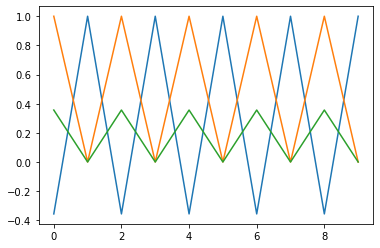

In [175]:
import matplotlib.pyplot as plt 
plt.figure()
plt.plot(alphas_0)
plt.plot(alphas_1)
plt.plot(alphas_2)

AFPL and FedAvg implementation 

In [4]:
### AFPL
torch.manual_seed(42)
np.random.seed(0)
print(torch.cuda.is_available)
save_dir = 'checkpoints/test_adaptive_a4'
n_epochs = settings['n_epochs']
log_interval = settings['log_interval']
n_clients = settings['n_clients']
total_clients = settings['total_clients']
dataset = settings['Dataset']
local_iterations = settings['local_iterations']
training_type = settings['type']
classes_per_user = settings['classes_per_user']
if training_type == 'local':
    training_loop_local(n_epochs,dataset,log_interval,n_clients,total_clients,save_dir,classes_per_user)
else:
    model_object=training_loop(n_epochs, dataset, log_interval, n_clients, total_clients, local_iterations, save_dir,training_type,classes_per_user)

<function is_available at 0x7f721eddd040>
[[2]
 [9]
 [1]]
selected clients:  [1, 2, 0]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/code/Federated_Averaging/models/FEMNIST_model.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


calculating accuracy
train loss:  (0, 0, 0)
test loss:  0.1369613674222248


In [6]:
print(model_object.accuracy)

None


In [4]:
np.random.seed(0)
import random
random.seed(1)
n_epochs = 2 #settings['n_epochs']
log_interval = settings['log_interval']
n_clients = settings['n_clients']
total_clients = settings['total_clients']
dataset = settings['Dataset']
local_iterations = settings['local_iterations']
federated_averaging = Federated_Averaging('cuda:0',Net(dataset=dataset),n_clients,total_clients,dataset=dataset)
#global_model = Global_Model('cuda:0',Net(dataset=dataset),n_clients,total_clients,dataset=dataset,same_as_federated=True)
federated_averaging.setup()
train_loader_f = federated_averaging.dataloader_dict

In [8]:
local_model = Local_Model('cuda:0',Net(dataset=dataset),dataset=dataset,total_clients=2)
save_dir = os.path.join('checkpoints', settings['experiment_name'])
losses = local_model.train_loop(save_dir,n_epochs=2)
print(losses)

{'client_0': OrderedDict([('conv1.weight', tensor([[[[-2.2076e-01, -1.4681e-01, -2.2826e-01,  5.1990e-02, -9.9439e-02],
          [-1.9695e-01,  6.7822e-02,  7.6442e-02, -4.8748e-02, -7.4418e-02],
          [-1.8513e-01, -1.2374e-01, -7.0976e-02, -1.6366e-01, -1.4200e-01],
          [ 1.1927e-01,  2.4164e-01,  4.4562e-02,  2.0372e-02,  1.7630e-01],
          [ 3.2460e-01,  1.9002e-01, -5.1026e-02,  2.5032e-01,  6.5362e-02]]],


        [[[-4.0961e-02,  1.9804e-01,  1.7474e-01,  3.9493e-02, -6.1324e-02],
          [ 1.3311e-01, -8.2787e-02,  1.9524e-01, -1.9742e-01, -2.3119e-01],
          [ 1.3142e-02,  1.6673e-02,  2.0788e-01, -2.0652e-01, -5.8594e-02],
          [ 2.5978e-01, -1.2091e-02, -1.2978e-01, -8.0553e-02, -1.9120e-01],
          [ 2.3004e-01,  1.4797e-01,  8.9497e-03, -9.3694e-02, -2.8590e-01]]],


        [[[-1.3756e-02, -2.0924e-01, -7.3095e-02, -1.0074e-01,  2.8784e-01],
          [-1.4877e-01, -2.5190e-01,  1.7431e-02, -4.3972e-02, -2.2195e-02],
          [-2.3175e-01, -

In [12]:
print(len(local_model.train_loader))
print(len(local_model.train_partition['client_1'])/16)
print(local_model.losses['client_1'])
print(local_model.test_losses['client_1'])
#print(local_model.client_models['client_99'])

1312
1311.875
[0.00017012915120044126, 6.192067290869806e-06]
[5.210436117766665e-05, 1.3951120124280129e-05]


In [9]:
federated_averaging = Federated_Averaging('cuda:0',Net(dataset=dataset),n_clients,total_clients,dataset=dataset)
print(federated_averaging.train_partition['client_0'][:10])


[13, 18, 32, 36, 39, 62, 66, 73, 83, 90]


In [14]:
for client in federated_averaging.train_partition:
    number = int(client[7:])
    dataset = MNIST_NIID_dataset(x,y,federated_averaging.train_partition,client=number)
    dataloader = DataLoader(dataset,batch_size=self.batch_size,shuffle=True)
    model = network.double().to(self.device)
    
                        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [10]:
federated_averaging = Federated_Averaging('cuda:0',Net(dataset=dataset),n_clients,total_clients,dataset=dataset)
print(federated_averaging.train_partition['client_0'][:10])

[13, 18, 32, 36, 39, 62, 66, 73, 83, 90]


In [11]:
#print(train_loader_f.keys())
federated_averaging.setup(epoch=2)
print(federated_averaging.selected_clients)



[95, 94, 5, 8, 83, 73, 66, 30, 60, 60, 58, 15, 43, 39, 72, 99, 94, 54, 44, 26, 3, 2, 46, 31, 38]


In [14]:
global_model.train_one_epoch(epoch=2)
print(global_model.selected_clients)

[95, 94, 5, 8, 83, 73, 66, 30, 60, 60, 58, 15, 43, 39, 72, 99, 94, 54, 44, 26, 3, 2, 46, 31, 38]
[95, 94, 5, 8, 83, 73, 66, 30, 60, 60, 58, 15, 43, 39, 72, 99, 94, 54, 44, 26, 3, 2, 46, 31, 38]


In [20]:
from numpy.random import default_rng 
np.random.seed(0)
selected_clients = np.random.choice(100,25,replace=False)
print(selected_clients)



[18 12 45 73  1  9 80 42 25 20 94 85 65 24 75 89  3 17 68 49 37 10 87 83
 82]


In [21]:
rng = default_rng()
selected_clients = rng.choice(100,25,replace=False)
print(selected_clients)

[83 37 73 17 15 61 75  2 28 55 11 57 80 59 70 90 33 34 22 56  3 84 62 20
 43]


In [25]:
import random 
l = [i for i in range(100)]
random.seed(1)
l_new = random.choices(l,k=25)
print(l_new)
l = [i for i in range(100)]
random.seed(1)
l_new = random.choices(l,k=25)
print(l_new)

[13, 84, 76, 25, 49, 44, 65, 78, 9, 2, 83, 43, 76, 0, 44, 72, 22, 94, 90, 3, 2, 54, 93, 38, 21]
[13, 84, 76, 25, 49, 44, 65, 78, 9, 2, 83, 43, 76, 0, 44, 72, 22, 94, 90, 3, 2, 54, 93, 38, 21]


In [46]:
import yaml 
stream = 'settings\train_settings.yaml'
with open('settings/train_settings.yaml','r') as file:
    settings = yaml.safe_load(file)
    
print(settings)

{'experiment_name': 'test', 'Date': 19102022, 'Dataset': 'MNIST_niid', 'n_clients': 25, 'total_clients': 100, 'network': 'Net', 'n_epochs': 100, 'local_iterations': 1, 'type': 'global', 'log_interval': 25}


In [22]:
if not os.path.isdir('checkpoints'):
    os.mkdir('checkpoints')
if not os.path.isdir(os.path.join('checkpoints',settings['experiment_name'])):
    os.mkdir(os.path.join('checkpoints',settings['experiment_name']))
save_dir = os.path.join('checkpoints',settings['experiment_name'])
if not os.path.isdir(os.path.join(save_dir,'model')):
    os.mkdir(os.path.join(save_dir,'model'))
import shutil 
shutil.copyfile('settings/train_settings.yaml',save_dir+'/train_settings.yaml')

'checkpoints/test/train_settings.yaml'

#### Federated training 

In [48]:
n_epochs = 2 #settings['n_epochs']
log_interval = settings['log_interval']
n_clients = settings['n_clients']
total_clients = settings['total_clients']
dataset = settings['Dataset']
local_iterations = settings['local_iterations']
federated_averaging = Federated_Averaging('cuda:0',Net(dataset=dataset),n_clients,total_clients,dataset=dataset)
print(federated_averaging.train_partition)

{'client_0': [17, 31, 41, 46, 55, 85, 94, 97, 125, 137, 144, 146, 160, 188, 197, 202, 225, 240, 245, 265, 295, 300, 312, 333, 343, 348, 352, 368, 386, 393, 404, 415, 418, 439, 445, 456, 469, 485, 499, 503, 517, 528, 532, 539, 545, 559, 571, 575, 594, 602, 615, 627, 628, 685, 694, 705, 708, 720, 725, 726, 734, 736, 740, 756, 758, 761, 766, 769, 777, 784, 791, 792, 796, 817, 823, 831, 858, 865, 876, 885, 913, 923, 925, 935, 963, 972, 976, 1009, 1013, 1016, 1025, 1026, 1045, 1059, 1063, 1064, 1067, 1086, 1101, 1105, 1120, 1141, 1170, 1193, 1207, 1214, 1219, 1223, 1236, 1237, 1239, 1247, 1254, 1267, 1279, 1289, 1294, 1296, 1319, 1329, 1339, 1344, 1362, 1384, 1388, 1404, 1419, 1434, 1439, 1453, 1457, 1464, 1475, 1484, 1505, 1519, 1534, 1542, 1543, 1593, 1598, 1616, 1621, 1641, 1657, 1666, 1713, 3, 6, 8, 14, 23, 24, 40, 59, 67, 70, 72, 77, 78, 99, 102, 104, 105, 112, 113, 124, 128, 134, 152, 174, 177, 184, 200, 201, 205, 208, 211, 224, 231, 248, 251, 269, 270, 276, 290, 309, 310, 315, 345, 3

In [27]:
n_epochs = 2 #settings['n_epochs']
log_interval = settings['log_interval']
n_clients = settings['n_clients']
total_clients = settings['total_clients']
dataset = settings['Dataset']
local_iterations = settings['local_iterations']
federated_averaging = Federated_Averaging('cuda:0',Net(dataset=dataset),n_clients,total_clients,dataset=dataset)
print(federated_averaging.batch_size)
train_losses = [] 
test_losses = [] 
best_test_loss = 1000000 
for i in range(n_epochs):
    federated_averaging.setup()
    train_loss = federated_averaging.train_clients_one_epoch(local_iterations)
    train_losses.append(train_loss)
    test_loss = federated_averaging.evaluate_clients_one_epoch()
    test_losses.append(test_loss)
    if test_loss < best_test_loss: 
        torch.save(federated_averaging.global_model.state_dict(),os.path.join(save_dir,'model','best_model.pt'))

    print('train loss: ',train_loss)
    print('test loss: ',test_loss)
        #torch.save(federated_averaging.global_model.state_dict(),os.path.join(save_dir,'model',str(i)+'_model.pt'))
    with open(os.path.join(save_dir,'loss.txt'),'w') as f:
        for i,_ in enumerate(train_losses):
            f.write('epoch: '+str(i)+' train loss: '+f"{train_losses[i]}"+' test loss: '+f"{test_losses[i]}\n")

16
train loss:  7.9793342153519236
test loss:  5.533759812449044
train loss:  2.0014806460897763
test loss:  3.334011469678082


In [30]:
model = Net(dataset=dataset)
model.load_state_dict(torch.load(os.path.join(save_dir,'model','best_model.pt'),map_location='cpu'))

<All keys matched successfully>

In [42]:
from sklearn.metrics import confusion_matrix
targets = [] 
predictions = [] 
model = model.double().cuda()
with torch.no_grad():
    for idx, i in enumerate(federated_averaging.selected_clients):
        dataloader_name = "data_" + str(i) + "test"
        for batch_idx, (data, target) in enumerate(federated_averaging.dataloader_dict[dataloader_name]):
            data = data.double().cuda()
            target = target.long().cuda()

            output = model(data)
            output_array = output.detach().cpu().numpy()
            predictions= predictions + np.argmax(output_array,axis=-1).tolist()
            targets= targets + target.detach().cpu().numpy().tolist()

print(confusion_matrix(predictions,targets)) 

/mimer/NOBACKUP/groups/snic2022-22-122/arthur/code/Federated_Averaging/models/FEMNIST_model.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


[[842   0   1  17]
 [  2 714   7  26]
 [  1   9 508  16]
 [  5   2   9 441]]


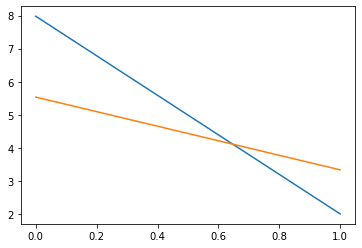

In [28]:
plt.plot(train_losses)
plt.plot(test_losses)

In [82]:

#selected_clients = np.random.randint(10,size=3)
learning_rate = 0.01 
momentum = 0.5
device = 'cuda:0'
batch_size = 16
n_epochs = 2 
global_model = Net().double().to(device)

for ii in range(n_epochs):
    print('epoch = ',ii)
    # select clients 
    rng = default_rng()
    selected_clients = rng.choice(10,size=3,replace=False)
    print('selected clients: ',selected_clients)
    # get data from clients 
    dataloader_dict = create_dataloaders(selected_clients)
    # need this for weights 
    total_data_length = calculate_total_length(selected_clients,train_data,clients)
    # initialize empty dict 
    global_model_intermediate = collections.OrderedDict([(name,torch.zeros(param.shape).to(device)) for name,param in global_model.state_dict().items()])
    #global_model_intermediate = {name: torch.zeros(param.shape).to(device) for name,param in global_model.state_dict().items()}
    for i in selected_clients:

        dataloader_name = "data_"+str(i)
        local_model = global_model 
        local_optimizer = optim.SGD(local_model.parameters(), lr=learning_rate, momentum=momentum)

        for batch_idx, (data,target) in enumerate(dataloader_dict[dataloader_name]):

            data = data.double().to(device)
            target = target.long().to(device)

            local_optimizer.zero_grad()
            output = local_model(data)
            loss = F.nll_loss(output,target)
            loss.backward()
            local_optimizer.step()
        #print('client ',str(i),' is done training')   
        weight = np.shape(train_data[clients[i]]['y'])[0] / total_data_length # take a good look at i! 
        #print('value before: ',global_model_intermediate['conv1.weight'][0,0,0,0])

        global_model_intermediate = collections.OrderedDict([(name, weight*param + global_model_intermediate[name]) for name,param in local_model.state_dict().items()])
        #print('value after:',global_model_intermediate['conv1.weight'][0,0,0,0])
    for name,param in global_model.named_parameters():
        param.data = global_model_intermediate[name]

        


epoch =  0
selected clients:  [3 9 0]
384
85
338
epoch =  1
selected clients:  [8 9 5]
322
85
338


In [77]:
print(global_model_intermediate['conv1.weight'][0,0,0,0])

tensor(-0.1723, device='cuda:0', dtype=torch.float64)


#### Global Network training

In [296]:
# set hyperparameters 
n_epochs = 100 
batch_size = 16 
learning_rate = 0.01 
momentum = 0.5 
random_seed = 42 
torch.manual_seed(random_seed )
device = 'cuda:0'
network = Net().double().to(device)
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)


In [19]:
data_train = FEMNIST_dataset(train_data,clients,'all')
train_loader = DataLoader(data_train, batch_size=batch_size,shuffle=True)
print(len(train_loader))

# Set the test set to be the same as with local training 

AssertionError: input should be integer specifying client or 'all'.

In [299]:
device = 'cuda:0'
network = Net().double().to(device)
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [300]:
train_losses = []
train_counter = []
test_losses = []
test_losses_other = []
log_interval = 10000
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test(epoch)
    test_other(epoch)

Train Epoch: 1 [0/71683 (0%)]	Loss: 4.147934


/tmp/ipykernel_3286192/628383843.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 1.7779, Accuracy: 20/38 (53%)


Test set: Avg. loss: 2.0003, Accuracy: 19/38 (50%)

Train Epoch: 2 [0/71683 (0%)]	Loss: 1.923993

Test set: Avg. loss: 0.9501, Accuracy: 25/38 (66%)


Test set: Avg. loss: 1.4334, Accuracy: 28/38 (74%)

Train Epoch: 3 [0/71683 (0%)]	Loss: 1.286323

Test set: Avg. loss: 0.8104, Accuracy: 26/38 (68%)


Test set: Avg. loss: 1.1948, Accuracy: 30/38 (79%)

Train Epoch: 4 [0/71683 (0%)]	Loss: 1.479930

Test set: Avg. loss: 0.7727, Accuracy: 25/38 (66%)


Test set: Avg. loss: 1.1880, Accuracy: 28/38 (74%)

Train Epoch: 5 [0/71683 (0%)]	Loss: 1.449225

Test set: Avg. loss: 0.7441, Accuracy: 25/38 (66%)


Test set: Avg. loss: 1.1750, Accuracy: 31/38 (82%)

Train Epoch: 6 [0/71683 (0%)]	Loss: 1.306950

Test set: Avg. loss: 0.7255, Accuracy: 29/38 (76%)


Test set: Avg. loss: 1.0273, Accuracy: 32/38 (84%)

Train Epoch: 7 [0/71683 (0%)]	Loss: 0.522003

Test set: Avg. loss: 0.7321, Accuracy: 25/38 (66%)


Test set: Avg. loss: 1.0193, Accuracy: 3


Test set: Avg. loss: 0.5142, Accuracy: 29/38 (76%)


Test set: Avg. loss: 0.8812, Accuracy: 32/38 (84%)

Train Epoch: 56 [0/71683 (0%)]	Loss: 0.313501

Test set: Avg. loss: 0.5237, Accuracy: 30/38 (79%)


Test set: Avg. loss: 0.8741, Accuracy: 32/38 (84%)

Train Epoch: 57 [0/71683 (0%)]	Loss: 0.426642

Test set: Avg. loss: 0.5095, Accuracy: 31/38 (82%)


Test set: Avg. loss: 0.9937, Accuracy: 31/38 (82%)

Train Epoch: 58 [0/71683 (0%)]	Loss: 0.582425

Test set: Avg. loss: 0.5287, Accuracy: 32/38 (84%)


Test set: Avg. loss: 0.8583, Accuracy: 32/38 (84%)

Train Epoch: 59 [0/71683 (0%)]	Loss: 0.274892

Test set: Avg. loss: 0.5407, Accuracy: 31/38 (82%)


Test set: Avg. loss: 0.9300, Accuracy: 30/38 (79%)

Train Epoch: 60 [0/71683 (0%)]	Loss: 0.457721

Test set: Avg. loss: 0.5387, Accuracy: 31/38 (82%)


Test set: Avg. loss: 0.8795, Accuracy: 31/38 (82%)

Train Epoch: 61 [0/71683 (0%)]	Loss: 1.028257

Test set: Avg. loss: 0.5326, Accuracy: 31/38 (82%)


Test set: Avg. loss: 0.9521, Accur

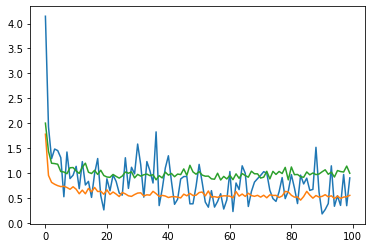

In [301]:
plot_loss_curves(train_losses,test_losses,test_losses_other)

#### Local Network training 

In [ ]:
# set hyperparameters 
n_epochs = 300 
batch_size = 16 
learning_rate = 0.01 
momentum = 0.5 
random_seed = 42 
torch.manual_seed(random_seed )
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [20]:
batch_size = 16
data_train = FEMNIST_dataset(train_data,clients,0)
train_loader = DataLoader(data_train, batch_size=batch_size,shuffle=True)
print(len(train_loader))
data_test = FEMNIST_dataset(test_data,clients,0)
test_loader = DataLoader(data_test, batch_size=batch_size,shuffle=False)
data_test_other_subject = FEMNIST_dataset(test_data,clients,1)
test_loader_other_subject = DataLoader(data_test_other_subject,batch_size=batch_size,shuffle=False)
print(len(test_loader))

22
3


In [258]:
device = 'cuda:0'
network = Net().double().to(device)
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [259]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [260]:
log_interval = 100
def train(epoch):
  network.train()
  test_loss = 0
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data.double().to(device))
    loss = F.nll_loss(output, target.long().to(device))
    test_loss += F.nll_loss(output, target.long().to(device), size_average=False).item()
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
  test_loss /= len(train_loader.dataset)
      #torch.save(network.state_dict(), '/results/model.pth')
      #t#orch.save(optimizer.state_dict(), '/results/optimizer.pth')

In [261]:
def test(epoch):
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      target = target.long().to(device)
      data = data.double().to(device)
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

test_losses_other = []
def test_other(epoch):
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader_other_subject:
      target = target.long().to(device)
      data = data.double().to(device)
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses_other.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))


In [262]:
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test(epoch)
    test_other(epoch)

/tmp/ipykernel_3286192/628383843.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/338 (0%)]	Loss: 4.139010

Test set: Avg. loss: 4.0854, Accuracy: 2/38 (5%)


Test set: Avg. loss: 4.4099, Accuracy: 3/38 (8%)

Train Epoch: 2 [0/338 (0%)]	Loss: 4.154768

Test set: Avg. loss: 4.0563, Accuracy: 2/38 (5%)


Test set: Avg. loss: 4.3749, Accuracy: 3/38 (8%)

Train Epoch: 3 [0/338 (0%)]	Loss: 4.094624

Test set: Avg. loss: 3.9941, Accuracy: 2/38 (5%)


Test set: Avg. loss: 4.2858, Accuracy: 3/38 (8%)

Train Epoch: 4 [0/338 (0%)]	Loss: 4.030908

Test set: Avg. loss: 3.8833, Accuracy: 3/38 (8%)


Test set: Avg. loss: 4.1341, Accuracy: 5/38 (13%)

Train Epoch: 5 [0/338 (0%)]	Loss: 3.889303

Test set: Avg. loss: 3.8501, Accuracy: 3/38 (8%)


Test set: Avg. loss: 4.1052, Accuracy: 5/38 (13%)

Train Epoch: 6 [0/338 (0%)]	Loss: 3.877735

Test set: Avg. loss: 3.8482, Accuracy: 2/38 (5%)


Test set: Avg. loss: 4.1045, Accuracy: 3/38 (8%)

Train Epoch: 7 [0/338 (0%)]	Loss: 3.903153

Test set: Avg. loss: 3.8058, Accuracy: 3/38 (8%)


Test set: Avg. loss: 4.0571, Accu


Test set: Avg. loss: 3.7908, Accuracy: 2/38 (5%)


Test set: Avg. loss: 4.1239, Accuracy: 2/38 (5%)

Train Epoch: 59 [0/338 (0%)]	Loss: 3.757448

Test set: Avg. loss: 3.7828, Accuracy: 2/38 (5%)


Test set: Avg. loss: 4.1211, Accuracy: 2/38 (5%)

Train Epoch: 60 [0/338 (0%)]	Loss: 3.736318

Test set: Avg. loss: 3.7829, Accuracy: 3/38 (8%)


Test set: Avg. loss: 4.1207, Accuracy: 3/38 (8%)

Train Epoch: 61 [0/338 (0%)]	Loss: 3.795476

Test set: Avg. loss: 3.7828, Accuracy: 2/38 (5%)


Test set: Avg. loss: 4.1363, Accuracy: 2/38 (5%)

Train Epoch: 62 [0/338 (0%)]	Loss: 3.543602

Test set: Avg. loss: 3.7680, Accuracy: 5/38 (13%)


Test set: Avg. loss: 4.1196, Accuracy: 4/38 (11%)

Train Epoch: 63 [0/338 (0%)]	Loss: 3.475049

Test set: Avg. loss: 3.7821, Accuracy: 2/38 (5%)


Test set: Avg. loss: 4.1402, Accuracy: 2/38 (5%)

Train Epoch: 64 [0/338 (0%)]	Loss: 3.532451

Test set: Avg. loss: 3.7688, Accuracy: 3/38 (8%)


Test set: Avg. loss: 4.1055, Accuracy: 5/38 (13%)

Train Epoch: 65 [0/


Test set: Avg. loss: 2.7242, Accuracy: 15/38 (39%)


Test set: Avg. loss: 3.6603, Accuracy: 10/38 (26%)

Train Epoch: 117 [0/338 (0%)]	Loss: 2.427806

Test set: Avg. loss: 2.6946, Accuracy: 16/38 (42%)


Test set: Avg. loss: 3.6020, Accuracy: 10/38 (26%)

Train Epoch: 118 [0/338 (0%)]	Loss: 2.908021

Test set: Avg. loss: 2.6639, Accuracy: 15/38 (39%)


Test set: Avg. loss: 3.5746, Accuracy: 10/38 (26%)

Train Epoch: 119 [0/338 (0%)]	Loss: 2.472038

Test set: Avg. loss: 2.6038, Accuracy: 18/38 (47%)


Test set: Avg. loss: 3.4844, Accuracy: 12/38 (32%)

Train Epoch: 120 [0/338 (0%)]	Loss: 2.283857

Test set: Avg. loss: 2.5417, Accuracy: 15/38 (39%)


Test set: Avg. loss: 3.5024, Accuracy: 12/38 (32%)

Train Epoch: 121 [0/338 (0%)]	Loss: 2.005886

Test set: Avg. loss: 2.5277, Accuracy: 12/38 (32%)


Test set: Avg. loss: 3.5201, Accuracy: 11/38 (29%)

Train Epoch: 122 [0/338 (0%)]	Loss: 2.064313

Test set: Avg. loss: 2.4206, Accuracy: 17/38 (45%)


Test set: Avg. loss: 3.4316, Accuracy: 1

Train Epoch: 174 [0/338 (0%)]	Loss: 1.112670

Test set: Avg. loss: 1.8397, Accuracy: 27/38 (71%)


Test set: Avg. loss: 3.2664, Accuracy: 17/38 (45%)

Train Epoch: 175 [0/338 (0%)]	Loss: 0.849447

Test set: Avg. loss: 1.9741, Accuracy: 23/38 (61%)


Test set: Avg. loss: 3.4575, Accuracy: 15/38 (39%)

Train Epoch: 176 [0/338 (0%)]	Loss: 0.942168

Test set: Avg. loss: 2.0309, Accuracy: 23/38 (61%)


Test set: Avg. loss: 3.4914, Accuracy: 15/38 (39%)

Train Epoch: 177 [0/338 (0%)]	Loss: 1.024985

Test set: Avg. loss: 1.8718, Accuracy: 25/38 (66%)


Test set: Avg. loss: 3.1910, Accuracy: 17/38 (45%)

Train Epoch: 178 [0/338 (0%)]	Loss: 0.854036

Test set: Avg. loss: 1.8634, Accuracy: 28/38 (74%)


Test set: Avg. loss: 3.1764, Accuracy: 17/38 (45%)

Train Epoch: 179 [0/338 (0%)]	Loss: 1.208907

Test set: Avg. loss: 1.9332, Accuracy: 23/38 (61%)


Test set: Avg. loss: 3.2821, Accuracy: 17/38 (45%)

Train Epoch: 180 [0/338 (0%)]	Loss: 0.625245

Test set: Avg. loss: 2.0509, Accuracy: 24/38 (63


Test set: Avg. loss: 4.2796, Accuracy: 17/38 (45%)

Train Epoch: 230 [0/338 (0%)]	Loss: 0.607374

Test set: Avg. loss: 2.1093, Accuracy: 27/38 (71%)


Test set: Avg. loss: 4.1127, Accuracy: 16/38 (42%)

Train Epoch: 231 [0/338 (0%)]	Loss: 0.407607

Test set: Avg. loss: 2.1427, Accuracy: 26/38 (68%)


Test set: Avg. loss: 4.1651, Accuracy: 16/38 (42%)

Train Epoch: 232 [0/338 (0%)]	Loss: 0.580130

Test set: Avg. loss: 2.2648, Accuracy: 26/38 (68%)


Test set: Avg. loss: 4.0761, Accuracy: 16/38 (42%)

Train Epoch: 233 [0/338 (0%)]	Loss: 0.369927

Test set: Avg. loss: 2.1344, Accuracy: 27/38 (71%)


Test set: Avg. loss: 4.2199, Accuracy: 16/38 (42%)

Train Epoch: 234 [0/338 (0%)]	Loss: 0.225148

Test set: Avg. loss: 2.1239, Accuracy: 27/38 (71%)


Test set: Avg. loss: 4.2886, Accuracy: 16/38 (42%)

Train Epoch: 235 [0/338 (0%)]	Loss: 0.437060

Test set: Avg. loss: 2.2997, Accuracy: 27/38 (71%)


Test set: Avg. loss: 4.3109, Accuracy: 17/38 (45%)

Train Epoch: 236 [0/338 (0%)]	Loss: 0.384


Test set: Avg. loss: 2.1830, Accuracy: 29/38 (76%)


Test set: Avg. loss: 4.7948, Accuracy: 18/38 (47%)

Train Epoch: 286 [0/338 (0%)]	Loss: 0.329954

Test set: Avg. loss: 2.1854, Accuracy: 29/38 (76%)


Test set: Avg. loss: 4.8047, Accuracy: 16/38 (42%)

Train Epoch: 287 [0/338 (0%)]	Loss: 0.189821

Test set: Avg. loss: 2.2781, Accuracy: 29/38 (76%)


Test set: Avg. loss: 4.7582, Accuracy: 16/38 (42%)

Train Epoch: 288 [0/338 (0%)]	Loss: 0.332718

Test set: Avg. loss: 2.1742, Accuracy: 29/38 (76%)


Test set: Avg. loss: 4.8713, Accuracy: 16/38 (42%)

Train Epoch: 289 [0/338 (0%)]	Loss: 0.179387

Test set: Avg. loss: 2.3415, Accuracy: 29/38 (76%)


Test set: Avg. loss: 4.8699, Accuracy: 16/38 (42%)

Train Epoch: 290 [0/338 (0%)]	Loss: 0.414196

Test set: Avg. loss: 2.4159, Accuracy: 27/38 (71%)


Test set: Avg. loss: 4.9411, Accuracy: 17/38 (45%)

Train Epoch: 291 [0/338 (0%)]	Loss: 0.171022

Test set: Avg. loss: 2.3455, Accuracy: 27/38 (71%)


Test set: Avg. loss: 4.7816, Accuracy: 1

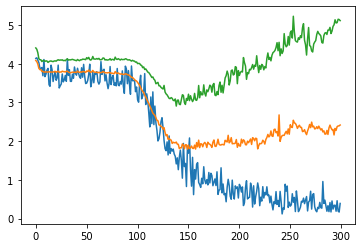

In [263]:
def plot_loss_curves(train_losses,test_losses,test_losses_other):
    plt.plot(train_losses)
    plt.plot(test_losses)
    plt.plot(test_losses_other)

plot_loss_curves(train_losses,test_losses,test_losses_other)

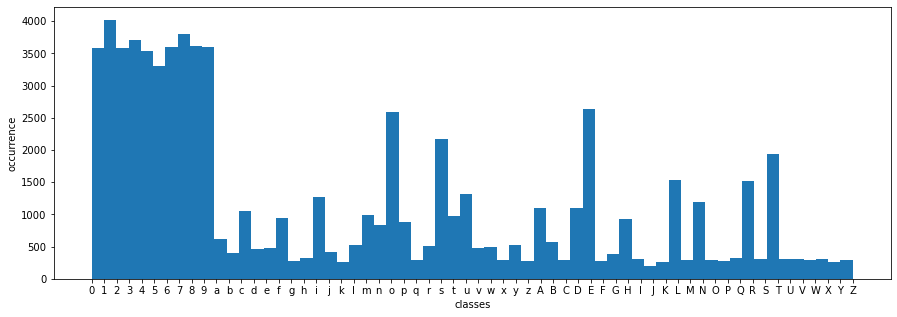

In [185]:
plot_histogram_classes_FEMNIST_whole(train_data)

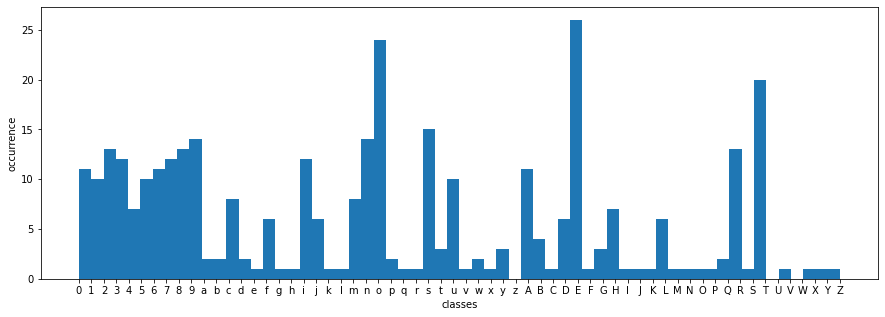

In [101]:
plot_histogram_classes_FEMNIST(train_data,2)

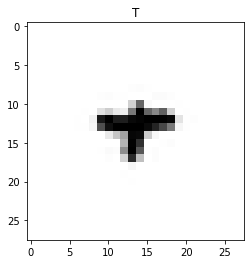

In [69]:
plot_random_sample_mnist(train_data,clients)